# Intro to GraphX

Useful documentation:

 - https://spark.apache.org/docs/latest/graphx-programming-guide.html
 - https://spark.apache.org/docs/latest/api/java/org/apache/spark/graphx/Pregel.html
 - https://docs.databricks.com/spark/latest/graph-analysis/graph-analysis-graphx-tutorial.html 

Welcome to Scala!

In [2]:
val x:Int = 0

x: Int = 0


In [3]:
println("x = " + x)

x = 0


In [4]:
import org.apache.spark.graphx._

import org.apache.spark.graphx._


## Creating graphs
Add some vertices:

In [5]:
val myVertices1 = sc.makeRDD(Array(
    (1L, "Alice"), 
    (2L, "Bob"),
    (3L, "Charlie"), 
    (4L, "John Doe"), 
    (5L, "Eve"),
    (6L, "Max")
))

val myVertices = sc.makeRDD(Array(
    (1L, "Alice"), 
    (2L, "Bob"),
    (3L, "Charlie"), 
    (4L, "John Doe"), 
    (5L, "Eve")
)) 

myVertices1: org.apache.spark.rdd.RDD[(Long, String)] = ParallelCollectionRDD[0] at makeRDD at <console>:28
myVertices: org.apache.spark.rdd.RDD[(Long, String)] = ParallelCollectionRDD[1] at makeRDD at <console>:37


Add edges with attributes:

In [6]:
val myEdges = sc.makeRDD(Array(
    Edge(1L, 2L, "is-friends-with"),
    Edge(2L, 3L, "is-friends-with"), 
    Edge(3L, 4L, "is-friends-with"),
    Edge(4L, 5L, "follows"), 
    Edge(3L, 5L, "follows")
))

myEdges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[String]] = ParallelCollectionRDD[2] at makeRDD at <console>:28


Create a graph:

In [7]:
val nonConsistentGraph = Graph(myVertices1, myEdges)
val consistentGraph = Graph(myVertices, myEdges)
val myGraph = consistentGraph

nonConsistentGraph: org.apache.spark.graphx.Graph[String,String] = org.apache.spark.graphx.impl.GraphImpl@38f79863
consistentGraph: org.apache.spark.graphx.Graph[String,String] = org.apache.spark.graphx.impl.GraphImpl@4866e426
myGraph: org.apache.spark.graphx.Graph[String,String] = org.apache.spark.graphx.impl.GraphImpl@4866e426


Look at vertices, edges and triplets:

In [8]:
myGraph.vertices.collect

res2: Array[(org.apache.spark.graphx.VertexId, String)] = Array((1,Alice), (2,Bob), (3,Charlie), (4,John Doe), (5,Eve))


In [9]:
myGraph.edges.collect

res3: Array[org.apache.spark.graphx.Edge[String]] = Array(Edge(1,2,is-friends-with), Edge(2,3,is-friends-with), Edge(3,4,is-friends-with), Edge(4,5,follows), Edge(3,5,follows))


In [10]:
myGraph.triplets.collect

res4: Array[org.apache.spark.graphx.EdgeTriplet[String,String]] = Array(((1,Alice),(2,Bob),is-friends-with), ((2,Bob),(3,Charlie),is-friends-with), ((3,Charlie),(4,John Doe),is-friends-with), ((4,John Doe),(5,Eve),follows), ((3,Charlie),(5,Eve),follows))


Iterate over all triplets:

In [11]:
myGraph.triplets.map(
  triplet => triplet.srcAttr + " " + triplet.attr + " " + triplet.dstAttr
).collect.foreach(println(_))

Alice is-friends-with Bob
Bob is-friends-with Charlie
Charlie is-friends-with John Doe
John Doe follows Eve
Charlie follows Eve


## Simple graph analysis
Compute pagerank:

In [12]:
val myPageRankGraph = myGraph.pageRank(0.0001)

myPageRankGraph: org.apache.spark.graphx.Graph[Double,Double] = org.apache.spark.graphx.impl.GraphImpl@192e153f


In [13]:
myPageRankGraph.vertices.collect

res6: Array[(org.apache.spark.graphx.VertexId, Double)] = Array((1,0.4390416708169825), (2,0.8122270910114175), (3,1.1294346981766874), (4,0.9190514175420748), (5,1.7002451224528383))


In [14]:
myGraph.pageRank(0.0001).vertices.join(myVertices).takeOrdered(1)(Ordering[Double].reverse.on(x => x._2._1))

res7: Array[(org.apache.spark.graphx.VertexId, (Double, String))] = Array((5,(1.7002451224528383,Eve)))


In [15]:
myGraph
  .inDegrees // computes in Degrees
  .foreach(x => println(x._1 + " has " + x._2 + " in degrees."))

2 has 1 in degrees.
4 has 1 in degrees.
3 has 1 in degrees.
5 has 2 in degrees.


## Pregel program example

Goal: collect all the names of friends and followers in all the vertices. 
In every step all vertices send their names to all their connections, and merge together.

Initialize the graph such that all vertices start with empty set:


In [16]:
val initialGraph = myGraph.mapVertices((_,v) => Set(v))

initialGraph: org.apache.spark.graphx.Graph[scala.collection.immutable.Set[String],String] = org.apache.spark.graphx.impl.GraphImpl@69c39a4b


In [17]:
initialGraph.vertices.collect

res9: Array[(org.apache.spark.graphx.VertexId, scala.collection.immutable.Set[String])] = Array((1,Set(Alice)), (2,Set(Bob)), (3,Set(Charlie)), (4,Set(John Doe)), (5,Set(Eve)))


Run Pregel for 1 step:

In [18]:
val g = Pregel(initialGraph,                                   //  Graph<VD,ED> graph
               Set[String](),                                  //  A initialMsg
               1,                                              //  int maxIterations,
               activeDirection = EdgeDirection.Out)(           //  EdgeDirection activeDirection,
               (id, value, message) => value union message,    //  scala.Function3<Object,VD,A,VD> vprog
               triplet =>                                      //  scala.Function1<EdgeTriplet<VD,ED>,scala.collection.Iterator<scala.Tuple2<Object,A>>> sendMsg,
                    Iterator((triplet.dstId, triplet.srcAttr)),
               (a,b) => a union b                              //  mergeMsg
              )              

g.vertices.collect

g: org.apache.spark.graphx.Graph[scala.collection.immutable.Set[String],String] = org.apache.spark.graphx.impl.GraphImpl@61ce1855
res10: Array[(org.apache.spark.graphx.VertexId, scala.collection.immutable.Set[String])] = Array((1,Set(Alice)), (2,Set(Bob, Alice)), (3,Set(Charlie, Bob)), (4,Set(John Doe, Charlie)), (5,Set(Eve, John Doe, Charlie)))


Run Pregel for 2 steps:

In [19]:
val g = Pregel(initialGraph,                                   //  Graph<VD,ED> graph
               Set[String](),                                  //  A initialMsg
               2,                                              //  int maxIterations,
               activeDirection = EdgeDirection.Out)(           //  EdgeDirection activeDirection,
               (id, value, message) => value union message,    //  scala.Function3<Object,VD,A,VD> vprog
               triplet =>                                      //  scala.Function1<EdgeTriplet<VD,ED>,scala.collection.Iterator<scala.Tuple2<Object,A>>> sendMsg,
                    Iterator((triplet.dstId, triplet.srcAttr)),
               (a,b) => a union b                              //  mergeMsg
              )              

g.vertices.collect

g: org.apache.spark.graphx.Graph[scala.collection.immutable.Set[String],String] = org.apache.spark.graphx.impl.GraphImpl@2e725f6e
res11: Array[(org.apache.spark.graphx.VertexId, scala.collection.immutable.Set[String])] = Array((1,Set(Alice)), (2,Set(Bob, Alice)), (3,Set(Charlie, Bob, Alice)), (4,Set(John Doe, Charlie, Bob)), (5,Set(Eve, John Doe, Charlie, Bob)))


Run Pregel for 3 steps:

In [20]:
val g = Pregel(initialGraph,                                   //  Graph<VD,ED> graph
               Set[String](),                                  //  A initialMsg
               3,                                              //  int maxIterations,
               activeDirection = EdgeDirection.Out)(           //  EdgeDirection activeDirection,
               (id, value, message) => value union message,    //  scala.Function3<Object,VD,A,VD> vprog
               triplet =>                                      //  scala.Function1<EdgeTriplet<VD,ED>,scala.collection.Iterator<scala.Tuple2<Object,A>>> sendMsg,
                    Iterator((triplet.dstId, triplet.srcAttr)),
               (a,b) => a union b                              //  mergeMsg
              )              

g.vertices.collect

g: org.apache.spark.graphx.Graph[scala.collection.immutable.Set[String],String] = org.apache.spark.graphx.impl.GraphImpl@76711534
res12: Array[(org.apache.spark.graphx.VertexId, scala.collection.immutable.Set[String])] = Array((1,Set(Alice)), (2,Set(Bob, Alice)), (3,Set(Charlie, Bob, Alice)), (4,Set(John Doe, Charlie, Bob, Alice)), (5,Set(Eve, Bob, Alice, John Doe, Charlie)))


The same but with more explicit type definitions:

In [21]:

// Vertex program - a function to apply to each vertex on a received message
def vprog(id:VertexId, value:Set[String], message:Set[String]): Set[String] = {
    value union message
}

// Send function: 
def sendMsg(et:EdgeTriplet[Set[String],String]): Iterator[Tuple2[VertexId,Set[String]]] = {                 
                    Iterator((et.dstId, et.srcAttr))
}

def mergeMsg(a:Set[String],b:Set[String]): Set[String] = {
    a union b
} 

val g = Pregel(initialGraph,                                 //  Graph<VD,ED> graph
               Set[String](),                                //  A initialMsg
               4,                                            //  int maxIterations,
               activeDirection = EdgeDirection.Out)(         //  EdgeDirection activeDirection,
               vprog,                                        //  scala.Function3<Object,VD,A,VD> vprog
               sendMsg ,                                     //  scala.Function1<EdgeTriplet<VD,ED>,scala.collection.Iterator<scala.Tuple2<Object,A>>> sendMsg,
               mergeMsg                                      //  mergeMsg: (A, A) => A
              )              

g.vertices.collect

vprog: (id: org.apache.spark.graphx.VertexId, value: Set[String], message: Set[String])Set[String]
sendMsg: (et: org.apache.spark.graphx.EdgeTriplet[Set[String],String])Iterator[(org.apache.spark.graphx.VertexId, Set[String])]
mergeMsg: (a: Set[String], b: Set[String])Set[String]
g: org.apache.spark.graphx.Graph[scala.collection.immutable.Set[String],String] = org.apache.spark.graphx.impl.GraphImpl@23e031ad
res13: Array[(org.apache.spark.graphx.VertexId, scala.collection.immutable.Set[String])] = Array((1,Set(Alice)), (2,Set(Bob, Alice)), (3,Set(Charlie, Bob, Alice)), (4,Set(John Doe, Charlie, Bob, Alice)), (5,Set(Eve, Bob, Alice, John Doe, Charlie)))


# Zadanie domowe

## 1. Wczytać graf Facebooka, krawędzie z pliku musae_facebook_edges.csv, atrybuty page_name oraz page_type z pliku musae_facebook_target.csv.  Policzyć liczbę krawędzi i wierzchołków. (1 p.)

Pobrano odpowiednie pliki csv z Kaggle.

In [22]:
import org.apache.spark.sql.Row

import org.apache.spark.sql.Row


In [23]:
val targetCsvPath = "C:\\Users\\mikol\\Desktop\\INFORMATYKA\\MGR\\ADZD\\lab5\\musae_facebook_target.csv"
val edgesCsvPath = "C:\\Users\\mikol\\Desktop\\INFORMATYKA\\MGR\\ADZD\\lab5\\musae_facebook_edges.csv"

targetCsvPath: String = C:\Users\mikol\Desktop\INFORMATYKA\MGR\ADZD\lab5\musae_facebook_target.csv
edgesCsvPath: String = C:\Users\mikol\Desktop\INFORMATYKA\MGR\ADZD\lab5\musae_facebook_edges.csv


In [24]:
val target = spark.read.option("header","true").csv(s"file:///$targetCsvPath")

target: org.apache.spark.sql.DataFrame = [id: string, facebook_id: string ... 2 more fields]


In [25]:
val fbVertices = target.select("id", "page_name", "page_type").rdd.map {
    case Row(id: String, pageName: String, pageType: String) =>
        (id.toLong, (pageName, pageType))
}

fbVertices: org.apache.spark.rdd.RDD[(Long, (String, String))] = MapPartitionsRDD[529] at map at <console>:30


In [26]:
val edges = spark.read.option("header","true").csv(s"file:///$edgesCsvPath")

edges: org.apache.spark.sql.DataFrame = [id_1: string, id_2: string]


In [27]:
val fbEdges = edges.rdd.map {
    case Row(id1: String, id2: String) =>
        Edge[Long](id1.toLong, id2.toLong)
}

fbEdges: org.apache.spark.rdd.RDD[org.apache.spark.graphx.Edge[Long]] = MapPartitionsRDD[545] at map at <console>:30


In [28]:
val fbGraph = Graph(fbVertices, fbEdges)

fbGraph: org.apache.spark.graphx.Graph[(String, String),Long] = org.apache.spark.graphx.impl.GraphImpl@6881a3e6


In [29]:
fbGraph.numVertices

res14: Long = 22470


In [30]:
fbGraph.numEdges

res15: Long = 171002


## 2. Sprawdzić czy graf jest spójny. Czy dwa podgrafy utworzone dla typów strony politician oraz company też są spójne? (1 p.)

In [31]:
def isGraphConsistent(graph: Graph[_, _]): Boolean = {
    graph.connectedComponents.vertices.map(_._2).distinct.count == 1
}

isGraphConsistent: (graph: org.apache.spark.graphx.Graph[_, _])Boolean


In [32]:
// test
isGraphConsistent(nonConsistentGraph)

res16: Boolean = false


In [33]:
// test
isGraphConsistent(consistentGraph)

res17: Boolean = true


In [34]:
isGraphConsistent(fbGraph)

res18: Boolean = true


In [35]:
val politicianFbGraph = fbGraph.subgraph(vpred = (id, attr) => attr._2 == "politician")
println(politicianFbGraph.numVertices)
println(politicianFbGraph.numEdges)

5768
36909


politicianFbGraph: org.apache.spark.graphx.Graph[(String, String),Long] = org.apache.spark.graphx.impl.GraphImpl@5537190d


In [36]:
val companyFbGraph = fbGraph.subgraph(vpred = (id, attr) => attr._2 == "company")
println(companyFbGraph.numVertices)
println(companyFbGraph.numEdges)

6495
20145


companyFbGraph: org.apache.spark.graphx.Graph[(String, String),Long] = org.apache.spark.graphx.impl.GraphImpl@36fa5f7d


In [37]:
isGraphConsistent(politicianFbGraph)

res21: Boolean = false


In [38]:
isGraphConsistent(companyFbGraph)

res22: Boolean = false


## 3. Spośród 1000 stron o najwyższym PageRank znaleźć 50 takich (wypisać page_name i page_type), które mają najmniej połączeń oraz 50 o największej liczbie połączeń. Który typ strony był dominujący w każdej z tych kategorii? Narysować wykres zależności PageRank od liczby krawędzi dla wierzchołków (scatter plot) (2 p.)


In [39]:
val ranks = fbGraph.pageRank(0.0001).vertices

ranks: org.apache.spark.graphx.VertexRDD[Double] = VertexRDDImpl[2511] at RDD at VertexRDD.scala:57


In [40]:
val degrees = fbGraph.degrees

degrees: org.apache.spark.graphx.VertexRDD[Int] = VertexRDDImpl[2521] at RDD at VertexRDD.scala:57


In [41]:
import org.apache.spark.graphx.VertexId

def unpack(x: (VertexId, ((Double, (String, String)), Int))): (VertexId, Double, String, String, Int) = {
    (x._1, x._2._1._1, x._2._1._2._1, x._2._1._2._2, x._2._2)
}

val top1000ranks = ranks.join(fbVertices).join(degrees).map(unpack).takeOrdered(1000)(Ordering[Double].reverse.on(x => x._2))

import org.apache.spark.graphx.VertexId
unpack: (x: (org.apache.spark.graphx.VertexId, ((Double, (String, String)), Int)))(org.apache.spark.graphx.VertexId, Double, String, String, Int)
top1000ranks: Array[(org.apache.spark.graphx.VertexId, Double, String, String, Int)] = Array((21729,118.94062246226493,The Obama White House,government,659), (22208,67.13872903779735,U.S. Department of State: Consular Affairs,government,205), (21781,56.441613845721264,Microsoft,company,14), (22440,55.24474131605631,City of Los Altos Police Department,government,43), (22057,48.04856548641234,The Connecticut National Guard,government,68), (22438,47.83973751107938,Federica Mogherini,politician,104), (22329,47.03110185659073,NHTSA,government,105), (20415,42.78414021359821,Joachim Herrmann,politician,320), ...


In [42]:
val maxs = sc.makeRDD(top1000ranks).takeOrdered(50)(Ordering[Int].reverse.on(_._5))

maxs: Array[(org.apache.spark.graphx.VertexId, Double, String, String, Int)] = Array((16895,20.611043303460775,U.S. Army,government,709), (19743,34.63886769999217,The White House,government,678), (21729,118.94062246226493,The Obama White House,government,659), (14497,16.245459331338928,U.S. Army Chaplain Corps,government,650), (10379,12.346423772469661,U.S. Department of State,government,468), (19347,25.577927493566285,FEMA Federal Emergency Management Agency,government,448), (21120,10.07828348764197,European Parliament,government,417), (15236,6.834541980826804,United States Air Force,government,375), (10426,6.95461885867345,Los Angeles District, U.S. Army Corps of Engineers,government,370), (11003,8.344303166882863,Barack Obama,politician,341), (13294,6.047145315385699,European Commiss...


In [ ]:
val mins = sc.makeRDD(top1000ranks).takeOrdered(50)(Ordering[Int].on(_._5))

In [44]:
maxs.groupBy(_._4).mapValues(_.length).toList.sortBy(_._2).last

res23: (String, Int) = (government,38)


In [45]:
mins.groupBy(_._4).mapValues(_.length).toList.sortBy(_._2).last

res24: (String, Int) = (company,28)


In [46]:
val top1000ranksStrings = top1000ranks.map(x => s"${x._2},${x._5}")

top1000ranksStrings: Array[String] = Array(118.94062246226493,659, 67.13872903779735,205, 56.441613845721264,14, 55.24474131605631,43, 48.04856548641234,68, 47.83973751107938,104, 47.03110185659073,105, 42.78414021359821,320, 36.55870819775853,148, 36.20924476176661,83, 34.63886769999217,678, 31.765609594721898,65, 30.532277625782353,74, 29.641706896456522,224, 29.088654164718225,63, 28.650085613946775,94, 28.559749806264737,104, 28.34340714898279,87, 27.4708496839289,38, 26.42019668805966,112, 25.989419727097573,92, 25.577927493566285,448, 25.058204594289638,330, 24.597737617871704,195, 23.417557163818678,174, 23.251635225142444,145, 22.84975735303852,26, 22.67540638575376,14, 22.058973746042643,46, 21.882670018181418,101, 21.785334081719263,106, 21.7360092335009,86, 21.374762071191277...


In [47]:
%%python
import csv
import matplotlib.pyplot as plt

ranks = []
degrees = []
with open('results.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header=True   
    for row in reader:
        if header:
            header = False
        else:
            row = ', '.join(row)
            x, y = (row.split(','))
            x = float(x)
            y = int(y)
            ranks.append(x)
            degrees.append(y)

plt.scatter(ranks, degrees)
plt.xlabel('rank')
plt.ylabel('degree')
# plt.show()

Text(0, 0.5, 'degree')

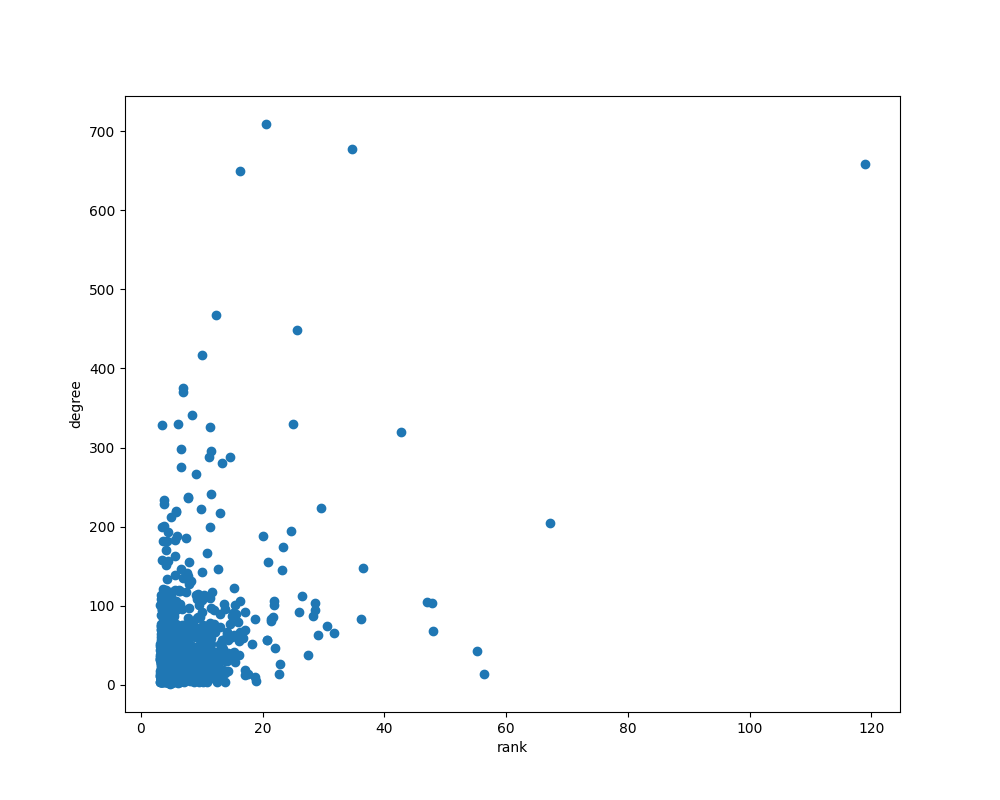

In [48]:
%%python
from IPython.display import Image
Image(filename='Figure_1.png') 

## 4. Korzystając z Pregel API zaimplementować następujący algorytm. W pierwszym kroku wybrana strona publikuje post fake news. W kolejnym kroku ten post publikowany jest przez ⅓ losowo wybranych kontaktów tej strony. W dalszych krokach, dla każdej strony, która opublikowała już ten post, losowo wybrane ⅓ jej kontaktów publikuje go u siebie. Pokazać jak zmienia się liczba stron które opublikowały post w zależności od liczby kroków. (2 p.)

In [49]:
val randomId = fbGraph.vertices.takeSample(false, 1)(0)._1
val repostGraph = fbGraph.mapVertices((id,_) => if (id == randomId) true else false)

randomId: org.apache.spark.graphx.VertexId = 7052
repostGraph: org.apache.spark.graphx.Graph[Boolean,Long] = org.apache.spark.graphx.impl.GraphImpl@393168fb


In [50]:
import scala.util.Random

val rand = new Random(250)

import scala.util.Random
rand: scala.util.Random = scala.util.Random@fc40e4b


In [51]:
for (sampleSize <- 2 to 5) {
    println("------------------------------------")
    println(s"Probability of repost: 1/$sampleSize\n")
    for (maxIterations <- 1 to 10){

    val g = Pregel(repostGraph,                                    //  Graph<VD,ED> graph
                   true,                                           //  A initialMsg      
                   maxIterations,                                              //  int maxIterations,
                   activeDirection = EdgeDirection.Out)(           //  EdgeDirection activeDirection,
                   (id, value, message) => value || (message && rand.nextInt(sampleSize)==0), //  scala.Function3<Object,VD,A,VD> vprog
                   triplet =>                                      //  scala.Function1<EdgeTriplet<VD,ED>,scala.collection.Iterator<scala.Tuple2<Object,A>>> sendMsg,
                        Iterator((triplet.dstId, triplet.srcAttr)),
                   (a,b) => a && b                          //  mergeMsg
                  )              

        val postsNumber = g.subgraph(vpred = (v, d) => d).vertices.count
        println(s"MaxIterations: $maxIterations")
        println("Percentage: " + postsNumber / fbGraph.numVertices.toDouble)
    }
}

------------------------------------
Probability of repost: 1/2

MaxIterations: 1
Percentage: 0.5305295950155763
MaxIterations: 2
Percentage: 0.5543391188251001
MaxIterations: 3
Percentage: 0.5731642189586115
MaxIterations: 4
Percentage: 0.5875834445927904
MaxIterations: 5
Percentage: 0.59942145082332
MaxIterations: 6
Percentage: 0.6094348019581665
MaxIterations: 7
Percentage: 0.618380062305296
MaxIterations: 8
Percentage: 0.6257676902536715
MaxIterations: 9
Percentage: 0.6317311971517579
MaxIterations: 10
Percentage: 0.6379617267467734
------------------------------------
Probability of repost: 1/3

MaxIterations: 1
Percentage: 0.34913217623498
MaxIterations: 2
Percentage: 0.36328437917222967
MaxIterations: 3
Percentage: 0.37485536270583
MaxIterations: 4
Percentage: 0.38420115709835334
MaxIterations: 5
Percentage: 0.3919893190921228
MaxIterations: 6
Percentage: 0.39848687138406763
MaxIterations: 7
Percentage: 0.4048954161103694
MaxIterations: 8
Percentage: 0.4108589230084557
MaxIterat

## 5. Narysować wykres rozkładu stopnia wierzchołków w grafie w skali logarytmicznej. Można skorzystać z funkcji obliczającej histogram dla RDD. Czy sieć jest bezskalowa (scale-free)? https://barabasi.com/f/623.pdf  (2 p.)

In [79]:
val degreeCounts = fbGraph.degrees.groupBy(_._2).map{case (key, values) => (key, values.size)}.collect().sortBy(_._1)

println("counts = " + degreeCounts.map(_._2.toString).mkString("[",",","]"))
println("degree = " + degreeCounts.map(_._1.toString).mkString("[",",","]"))

counts = [2658,2307,1843,1516,1359,1114,974,811,731,618,555,494,452,391,380,333,348,316,265,264,233,227,213,193,200,192,149,145,151,127,132,112,130,102,107,107,89,85,70,74,67,70,76,69,59,49,51,52,45,48,54,35,53,34,36,36,37,27,38,37,33,41,19,27,22,21,29,25,32,19,20,15,19,19,16,19,13,13,10,11,12,8,18,9,8,12,13,12,10,13,7,9,8,13,4,7,8,3,13,5,8,5,3,10,11,8,7,5,5,4,3,11,4,6,4,7,5,3,3,7,7,5,3,2,4,2,3,1,3,3,3,3,3,3,1,1,5,2,3,4,4,3,3,4,3,2,4,1,1,1,1,1,3,3,1,1,1,1,1,2,1,1,1,1,1,2,3,1,2,2,2,1,2,1,1,2,1,1,1,2,3,1,1,1,2,1,1,1,1,3,1,1,2,2,1,1,2,1,1,1,1,1,2,1,1,2,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
degree = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122

degreeCounts: Array[(Int, Int)] = Array((1,2658), (2,2307), (3,1843), (4,1516), (5,1359), (6,1114), (7,974), (8,811), (9,731), (10,618), (11,555), (12,494), (13,452), (14,391), (15,380), (16,333), (17,348), (18,316), (19,265), (20,264), (21,233), (22,227), (23,213), (24,193), (25,200), (26,192), (27,149), (28,145), (29,151), (30,127), (31,132), (32,112), (33,130), (34,102), (35,107), (36,107), (37,89), (38,85), (39,70), (40,74), (41,67), (42,70), (43,76), (44,69), (45,59), (46,49), (47,51), (48,52), (49,45), (50,48), (51,54), (52,35), (53,53), (54,34), (55,36), (56,36), (57,37), (58,27), (59,38), (60,37), (61,33), (62,41), (63,19), (64,27), (65,22), (66,21), (67,29), (68,25), (69,32), (70,19), (71,20), (72,15), (73,19), (74,19), (75,16), (76,19), (77,13), (78,13), (79,10), (80,11), (81,...


In [74]:
val hist = fbGraph.degrees.map(_._2).histogram(30)
println("x = " + hist._2.map(_.toString).mkString("[", ",", "]"))
println("bins = " + hist._1.map(_.toString).mkString("[", ",", "]"))

x = [18595,2465,768,291,145,75,35,23,14,19,8,4,5,5,4,3,2,2,1,1,0,1,0,0,0,0,0,2,1,1]
bins = [1.0,24.6,48.2,71.8,95.4,119.0,142.6,166.2,189.8,213.4,237.0,260.6,284.2,307.8,331.4,355.0,378.6,402.2,425.8,449.4,473.0,496.6,520.2,543.8,567.4,591.0,614.6,638.2,661.8,685.4,709.0]


hist: (Array[Double], Array[Long]) = (Array(1.0, 24.6, 48.2, 71.8, 95.4, 119.0, 142.6, 166.2, 189.8, 213.4, 237.0, 260.6, 284.2, 307.8, 331.4, 355.0, 378.6, 402.2, 425.8, 449.4, 473.0, 496.6, 520.2, 543.8, 567.4, 591.0, 614.6, 638.2, 661.8, 685.4, 709.0),Array(18595, 2465, 768, 291, 145, 75, 35, 23, 14, 19, 8, 4, 5, 5, 4, 3, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1))


In [75]:
%%python
import matplotlib.pyplot as plt
import numpy as np

x = [18595,2465,768,291,145,75,35,23,14,19,8,4,5,5,4,3,2,2,1,1,0,1,0,0,0,0,0,2,1,1]
bins = [1.0,24.6,48.2,71.8,95.4,119.0,142.6,166.2,189.8,213.4,237.0,260.6,284.2,307.8,331.4,355.0,378.6,402.2,425.8,449.4,473.0,496.6,520.2,543.8,567.4,591.0,614.6,638.2,661.8,685.4,709.0]
logbins = np.logspace(np.log10(bins[0]), np.log(bins[-1]), len(bins))
plt.subplot(212)
plt.hist(x, bins=logbins)
plt.xscale('log')
# plt.show()

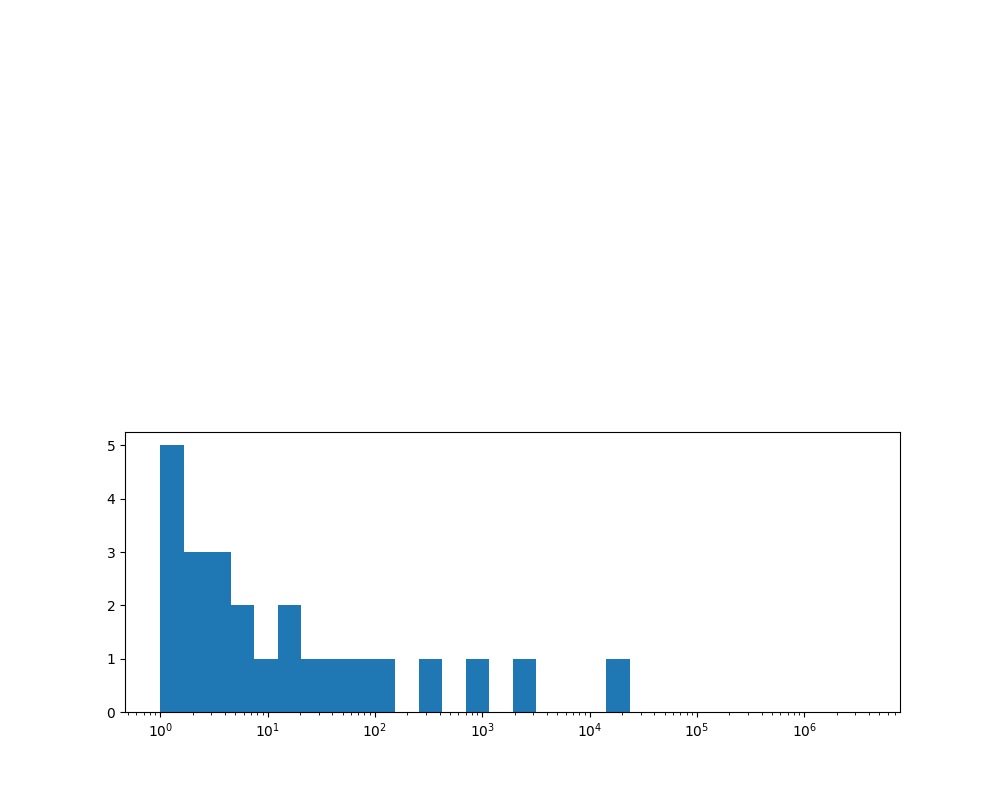

In [76]:
%%python
from IPython.display import Image
Image(filename='Figure_2.png') 

In [94]:
%%python
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import numpy as np

counts = [2658,2307,1843,1516,1359,1114,974,811,731,618,555,494,452,391,380,333,348,316,265,264,233,227,213,193,200,192,149,145,151,127,132,112,130,102,107,107,89,85,70,74,67,70,76,69,59,49,51,52,45,48,54,35,53,34,36,36,37,27,38,37,33,41,19,27,22,21,29,25,32,19,20,15,19,19,16,19,13,13,10,11,12,8,18,9,8,12,13,12,10,13,7,9,8,13,4,7,8,3,13,5,8,5,3,10,11,8,7,5,5,4,3,11,4,6,4,7,5,3,3,7,7,5,3,2,4,2,3,1,3,3,3,3,3,3,1,1,5,2,3,4,4,3,3,4,3,2,4,1,1,1,1,1,3,3,1,1,1,1,1,2,1,1,1,1,1,2,3,1,2,2,2,1,2,1,1,2,1,1,1,2,3,1,1,1,2,1,1,1,1,3,1,1,2,2,1,1,2,1,1,1,1,1,2,1,1,2,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
degree = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,155,156,157,158,162,163,166,167,168,169,170,171,172,174,177,178,181,182,183,185,188,189,191,193,194,195,196,199,201,203,205,212,214,216,217,218,220,222,224,225,226,229,233,234,236,237,240,241,244,256,257,260,266,275,280,288,290,296,298,320,326,328,330,333,338,341,351,364,370,375,380,387,408,417,448,468,504,650,659,678,709]

counts = list(map(lambda x: np.log(x), counts))
degree = list(map(lambda x: np.log(x), degree))
b, m = polyfit(degree, counts, 1)
print(m)

plt.plot(degree, counts, '.')
plt.plot(x, b + m * np.float64(x), '-')
# plt.show()

-1.8737129723472843


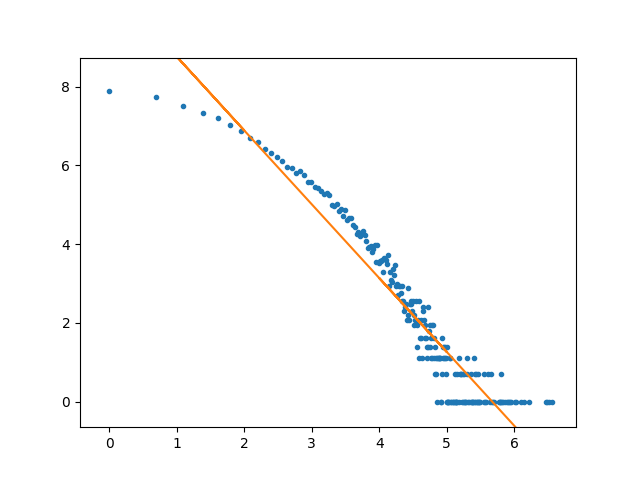

In [95]:
%%python
from IPython.display import Image
Image(filename='Figure_3.png') 

Współczynnik nie mieści się w przedziale (-2, -3), zatem sieć nie jest scale-free (choć niewiele brakuje). 

**Wykonał Mikołaj Sikora**